# Q - Learnの学習
## SarsaとQの違い
- Sarsaの行動価値関数Qの更新式
$$
    Q(s_t, a_t) = Q(s_t, a_t) + η*(R_{t+1} + μQ(s_{t+1}, a_{t+1}) - Q(s_t, a_t))
$$

- Q学習の行動価値関数Qの更新式
$$
Q(s_t, a_t) = Q(s_t, a_t) + η*(R_{t+1} + γ max_a Q(s_{t+1}, a) - Q(s_t, a_t)
$$

**Sarsaは$a_{t+1}$を更新に使用する**のに対して、**Q学習**は**a_{a+1}を更新に使用しない**ことが違いとして読み取れる。
方策を行動価値関数の更新に用いるものを方策オン型(ON-policy)と呼び、方策を行動価値関数の更新に用いないものを方策オフ型(OFF-policy)と呼ぶ

ε- Greedy法から生まれるランダム性が更新式に反映されない分、収束が早い(ε-greedy法は一定確率でランダムのaを取ることでコストを払い探索をしている。)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

/Users/2357gi/Sandbox/signatej/venv/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


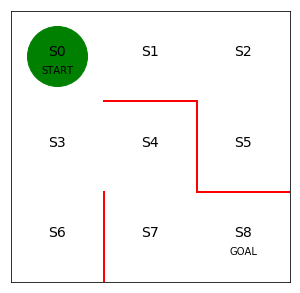

In [2]:
# 迷路の定義とpi_0の定義
# 図を描く大きさと、図の変数を宣言。
fig = plt.figure(figsize=(5, 5))
ax = plt.gca()

# make wall
plt.plot([1, 1], [0, 1], color='red', linewidth=2)
plt.plot([1, 2], [2, 2], color='red', linewidth=2)
plt.plot([2, 2], [2, 1], color='red', linewidth=2)
plt.plot([2, 3], [1, 1], color='red', linewidth=2)

# make points
plt.text(0.5, 2.5, 'S0', size=14, ha='center')
plt.text(1.5, 2.5, 'S1', size=14, ha='center')
plt.text(2.5, 2.5, 'S2', size=14, ha='center')
plt.text(0.5, 1.5, 'S3', size=14, ha='center')
plt.text(1.5, 1.5, 'S4', size=14, ha='center')
plt.text(2.5, 1.5, 'S5', size=14, ha='center')
plt.text(0.5, 0.5, 'S6', size=14, ha='center')
plt.text(1.5, 0.5, 'S7', size=14, ha='center')
plt.text(2.5, 0.5, 'S8', size=14, ha='center')
plt.text(0.5, 2.3, 'START', ha='center')
plt.text(2.5, 0.3, 'GOAL', ha='center')

# 描画範囲の設定とメモリを消す設定
ax.set_xlim(0, 3)
ax.set_ylim(0, 3)
plt.tick_params(axis='both', which='both', bottom='off', top='off',
                labelbottom='off', right='off', left='off', labelleft='off')

# 現在地に丸を描画する。
line, = ax.plot([0.5], [2.5], 'o', color = 'g', markersize=60)


# 初期の方策を決定するparams theta_0を設定

# 行は0~7, 列は移動方向で上右下左を表す。
theta_0 = np.array([[np.nan, 1, 1, np.nan],  
                   [np.nan, 1, np.nan, 1],
                    [np.nan, np.nan, 1, 1],
                   [1, 1, 1, np.nan],        
                   [np.nan, np.nan, 1, 1],   
                   [1, np.nan, np.nan, np.nan],  
                   [1, np.nan, np.nan, np.nan],  
                   [1, 1, np.nan, np.nan],       
                    ])

In [3]:
# 方策パラメータtheta_0を方策に変形する。初期の方策なので、ランダム、よって割合で実装する。


def simple_convert_into_pi_from_theta(theta):
    
    [m, n] = theta.shape
    pi = np.zeros((m, n))
    for i in range(0, m):
        pi[i, :] = theta[i, :] / np.nansum(theta[i, :])
    
    pi = np.where(np.isnan(pi), 0, pi)
    
    return pi

pi_0 = simple_convert_into_pi_from_theta(theta_0)
pi_0


array([[0.        , 0.5       , 0.5       , 0.        ],
       [0.        , 0.5       , 0.        , 0.5       ],
       [0.        , 0.        , 0.5       , 0.5       ],
       [0.33333333, 0.33333333, 0.33333333, 0.        ],
       [0.        , 0.        , 0.5       , 0.5       ],
       [1.        , 0.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        , 0.        ],
       [0.5       , 0.5       , 0.        , 0.        ]])

In [4]:
# 初期の行動価値関数Qを設定。
# 最初はランダムでパラメータを定義、theta_0をかけてnanを反映する。

[a, b] = theta_0.shape
Q = np.random.rand(a, b) * theta_0

In [5]:
# ε-greedy法を実装


def get_action(s, Q, epsilon, pi_0):
    direction = ["up", "right", "down", "left"]

    # 行動を決める
    if np.random.rand() < epsilon:
        # εの確率でランダムに動く
        next_direction = np.random.choice(direction, p=pi_0[s, :])
    else:
        # Qの最大値の行動を採用する
        next_direction = direction[np.nanargmax(Q[s, :])]

    # 行動をindexに
    if next_direction == "up":
        action = 0
    elif next_direction == "right":
        action = 1
    elif next_direction == "down":
        action = 2
    elif next_direction == "left":
        action = 3

    return action


def get_s_next(s, a, Q, epsilon, pi_0):
    direction = ["up", "right", "down", "left"]
    next_direction = direction[a]  # 行動aの方向

    # 行動から次の状態を決める
    if next_direction == "up":
        s_next = s - 3  # 上に移動するときは状態の数字が3小さくなる
    elif next_direction == "right":
        s_next = s + 1  # 右に移動するときは状態の数字が1大きくなる
    elif next_direction == "down":
        s_next = s + 3  # 下に移動するときは状態の数字が3大きくなる
    elif next_direction == "left":
        s_next = s - 1  # 左に移動するときは状態の数字が1小さくなる

    return s_next

In [16]:
# Q学習の実装


def Q_learning_old(s, a, r, s_next, Q, eta, gamma):
    
    if s_next == 8:
        Q[s, a] = Q[s, a] + eta * (r - Q[s, a])
    else:
        Q[s, a] = Q[s, a] + eta * (r + gamma + np.nanmax(Q[s_next, :] - Q[s, a]))
    
    return Q

In [17]:
# Q学習による行動価値関数Qの更新


def Q_learning(s, a, r, s_next, Q, eta, gamma):

    if s_next == 8:  # ゴールした場合
        Q[s, a] = Q[s, a] + eta * (r - Q[s, a])

    else:
        Q[s, a] = Q[s, a] + eta * (r + gamma * np.nanmax(Q[s_next,: ]) - Q[s, a])

    return Q

In [18]:
# Q学習で迷路を解く関数の定義。１試行ごとに実行される。というか試行そのもの
def goal_maze_rets_s_a_Q_old(Q, epsilon, eta, gamma, pi):
    s = 0  # スタート地点
    a = a_next = get_action(s, Q, epsilon, pi)  # 状態の行動
    s_a_history = [[0, np.nan]]  # エージェントの行動履歴
    
    while(1):  # ゴールするまでループ
        a = a_next  # 行動更新
        
        s_a_history[-1][1] = a
        # 現在の状態(一番最後なのでindexは-1を見てる)に行動を代入
        
        s_next = get_s_next(s, a, Q, epsilon, pi)
        # 次の行動を格納。s_t
        
        s_a_history.append([s_next, np.nan])
        # 次の状態を格納。
        
        if s_next == 8:
            r = 1  # ゴールにたどり着いたら報酬を与える。
            a_next = np.nan
        else:
            r = 0
            a_next = get_action(s_next, Q, epsilon, pi)
            # 次の行動関数a_nextを求める。
        
        # 価値関数を更新
        Q = Q_learning(s, a, r, s_next, Q, eta, gamma)
        
        if s_next == 8:
            break
        else:
            s = s_next
    return [s_a_history, Q]

In [19]:
def goal_maze_ret_s_a_Q(Q, epsilon, eta, gamma, pi):
    s = 0  # スタート地点
    a = a_next = get_action(s, Q, epsilon, pi)  # 初期の行動
    s_a_history = [[0, np.nan]]  # エージェントの移動を記録するリスト

    while (1):  # ゴールするまでループ
        a = a_next  # 行動更新

        s_a_history[-1][1] = a
        # 現在の状態（つまり一番最後なのでindex=-1）に行動を代入

        s_next = get_s_next(s, a, Q, epsilon, pi)
        # 次の状態を格納

        s_a_history.append([s_next, np.nan])
        # 次の状態を代入。行動はまだ分からないのでnanにしておく

        # 報酬を与え,　次の行動を求めます
        if s_next == 8:
            r = 1  # ゴールにたどり着いたなら報酬を与える
            a_next = np.nan
        else:
            r = 0
            a_next = get_action(s_next, Q, epsilon, pi)
            # 次の行動a_nextを求めます。

        # 価値関数を更新
        Q = Q_learning(s, a, r, s_next, Q, eta, gamma)

        # 終了判定
        if s_next == 8:  # ゴール地点なら終了
            break
        else:
            s = s_next

    return [s_a_history, Q]

In [20]:
# Q学習で迷路を解く

eta = 0.1
gamma = 0.9
epsilon = 0.5
v = np.nanmax(Q, axis=1)
is_continue = True
episode = 1

V = []
V.append(np.nanmax(Q, axis=1))

while is_continue:
    print("--"*10 + "episode: " + str(episode))
    
    # ε-greedyのepsilonを徐々に小さくする
    epsilon = epsilon / 2
    
    # Q学習で迷路を解き、移動した履歴と更新したQを求める。
    [s_a_history, Q] = goal_maze_rets_s_a_Q(Q, epsilon, eta, gamma, pi_0)
    
    # 状態価値の変化
    new_v = np.nanmax(Q, axis=1)
    print("--"*10 + "行動価値の最大値\n" + str(np.sum(np.abs(new_v - v))))
    v = new_v
    V.append(v)
    
    print("--"*10 + "迷路を解くのにかかったステップ数は"+str(len(s_a_history) - 1) + "です。")
    
    
    # 100ep繰り返す
    episode = episode + 1
    if episode > 100:
        is_continue = False

--------------------episode: 1
--------------------行動価値の最大値
14517.490160220521
--------------------迷路を解くのにかかったステップ数は16です。
--------------------episode: 2
--------------------行動価値の最大値
134378.20708019924
--------------------迷路を解くのにかかったステップ数は154です。
--------------------episode: 3
--------------------行動価値の最大値
308672.4015716547
--------------------迷路を解くのにかかったステップ数は1058です。
--------------------episode: 4
--------------------行動価値の最大値
54518.991961723244
--------------------迷路を解くのにかかったステップ数は546です。
--------------------episode: 5
--------------------行動価値の最大値
36670.91927834283
--------------------迷路を解くのにかかったステップ数は950です。
--------------------episode: 6
--------------------行動価値の最大値
17784.31416147358
--------------------迷路を解くのにかかったステップ数は1520です。
--------------------episode: 7
--------------------行動価値の最大値
4846.476239093787
--------------------迷路を解くのにかかったステップ数は6622です。
--------------------episode: 8
--------------------行動価値の最大値
0.11131356812707693
--------------------迷路を解くのにかかったステップ数は20です。
------------------